# Benchmark Analysis - H4

In [136]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [137]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [138]:
matplotlib.style.use('seaborn-v0_8')  

In [139]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [140]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [141]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [142]:
plot_save_dir = './plots/h4'

## Utils 

In [143]:
def get_path(*entries):
    return os.path.join(*entries)

In [144]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [145]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [146]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [147]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [148]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [149]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [150]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

In [151]:

def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

# H4
> Different compilers/backends may fallback to sequential algorithms, leading to better performance.

## `b4_1_merge_cutoff_wrapper_par`

### Time Comparison - `b4_1_merge_cutoff_wrapper_par`


Check how the runtime without constraining the threads develops with increasing input size

In [152]:
def get_b4_1_merge_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_1_merge_cutoff_wrapper_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_data_algo(*x) for x in instances]


# merge for plotting 
b4_1_merge_time_merged = pd.merge(*data, on='n')

b4_1_merge_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.521010e+01,4,9310.60
1,3.673580e+01,8,9436.41
2,4.646950e+01,16,9546.36
3,7.194550e+01,32,9818.93
4,1.057150e+02,64,10285.00
5,1.773060e+02,128,11237.40
6,3.214060e+02,256,11759.90
7,6.093160e+02,512,12089.90
8,7.837820e+03,1024,13222.60
9,1.223100e+04,2048,14324.40


### Strong Scaling - `b4_1_merge_cutoff_wrapper_par`
 
1 Million fixed input size with threads 1-64

In [153]:
def get_b4_1_merge_cutoff_wrapper_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_1_merge_cutoff_wrapper')
    
    ## b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_1_merge_cutoff_wrapper_par',
                                               core_list,
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_cutoff_wrapper_scaling_algo(*x) for x in instances]

b4_1_merge_cutoff_wrapper_strong_scaling_merged = pd.merge(*data, on='threads')


b4_1_merge_cutoff_wrapper_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.726888,0.500356
1,2,1.171128,0.731558
2,4,1.973147,0.927150
3,8,1.967493,1.091968
4,16,2.605413,1.041841
5,32,3.452688,1.135662
6,64,5.241518,1.087645


In [154]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_1_merge_cutoff_wrapper_efficiency = b4_1_merge_cutoff_wrapper_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] = b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] / b4_1_merge_cutoff_wrapper_efficiency['threads']
    

b4_1_merge_cutoff_wrapper_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.726888,0.500356
1,2,0.585564,0.365779
2,4,0.493287,0.231787
3,8,0.245937,0.136496
4,16,0.162838,0.065115
5,32,0.107897,0.035489
6,64,0.081899,0.016994


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/1363184798.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


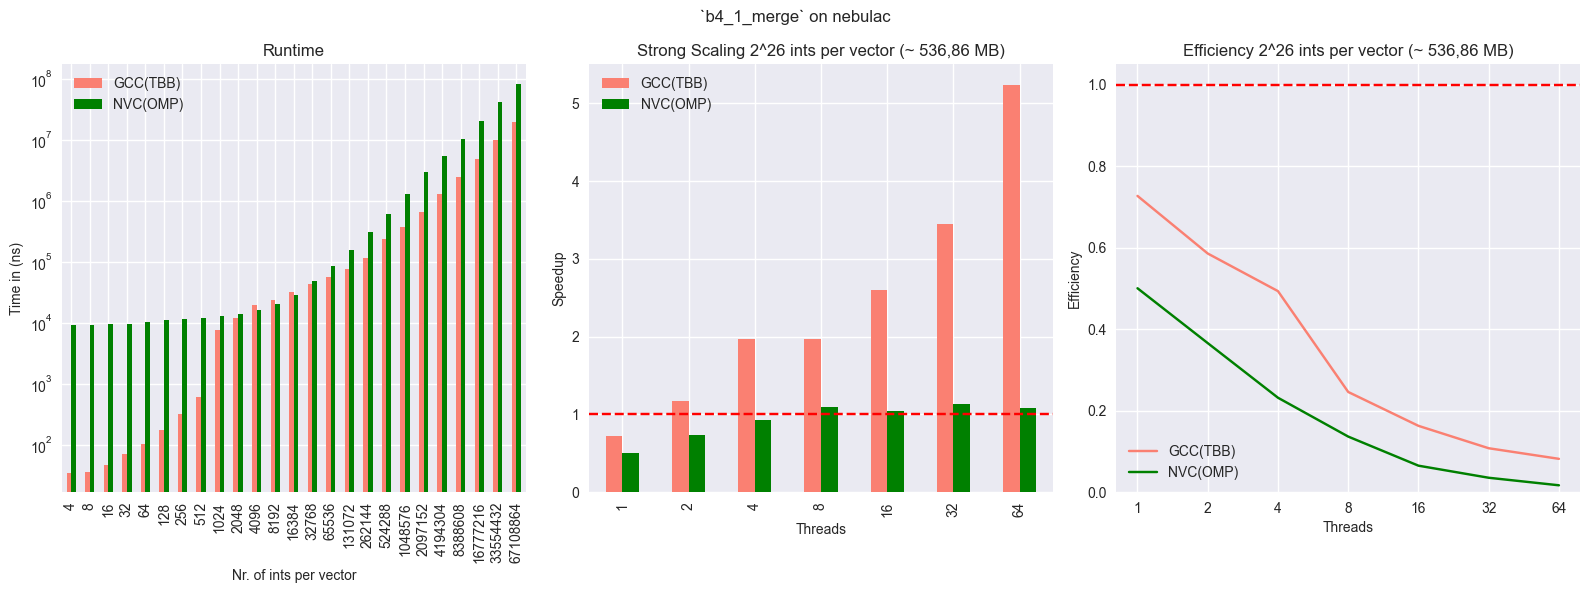

In [155]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b4_1_merge_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints per vector')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b4_1_merge_cutoff_wrapper_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints per vector (~ 536,86 MB)')






# plot efficiency
ax_3 = b4_1_merge_cutoff_wrapper_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints per vector (~ 536,86 MB)')



fig.suptitle(f"`b4_1_merge` on {device_name}")

fig.tight_layout()

plot(f"`b4_1_merge` {device_name}")

### Mbytes/Seconds

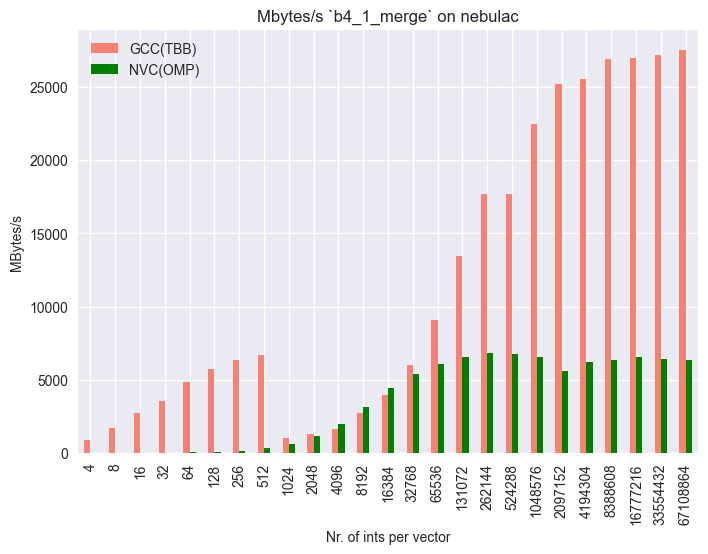

In [156]:
benchmark_name= 'b4_1_merge_cutoff_wrapper_par'
instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

b4_1_mbytes_sec_data = pd.merge(*data, on='n')

# plot mbytes
b4_1_mbytes_sec_data.plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR]
                                                    )


plt.ylabel('MBytes/s')
plt.xlabel('Nr. of ints per vector')
plt.title(f'Mbytes/s `b4_1_merge` on {device_name}')


plot(f'`b4_1_merge` Mbytes_s on {device_name}')

## `b4_2_stable_sort`


### Time Comparison - `b4_2_stable_sort_cutoff_already_sorted_par`

Check how the runtime without constraining the threads develops with increasing input size

In [157]:
def get_b4_2_stable_sort_cutoff_already_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_already_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_already_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_already_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,8.320120e+01,4,28014.9
1,9.288450e+01,8,34967.4
2,1.545500e+02,16,43365.4
3,2.256920e+02,32,52201.2
4,4.630860e+02,64,62152.1
5,7.820520e+02,128,62581.4
6,1.604890e+03,256,61033.9
7,1.085190e+04,512,69289.5
8,1.690360e+04,1024,67404.7
9,2.235570e+04,2048,72881.4


### Time Comparison - `b4_2_stable_sort_cutoff_decrement_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [158]:
def b4_2_stable_sort_cutoff_decrement_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_decrement_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_decrement_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_decrement_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_decrement_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,8.357390e+01,4,31708.8
1,9.022810e+01,8,39350.3
2,1.632920e+02,16,48689.4
3,2.246940e+02,32,58989.6
4,4.534740e+02,64,71330.2
5,7.884260e+02,128,71107.2
6,1.624510e+03,256,69523.9
7,1.106770e+04,512,70138.9
8,1.700910e+04,1024,71836.1
9,2.301340e+04,2048,73347.3


### Time Comparison - `b4_2_stable_sort_cutoff_not_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [159]:
def b4_2_stable_sort_cutoff_not_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_not_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_not_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_not_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_not_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,8.855360e+01,4,29446.8
1,9.890940e+01,8,39660.8
2,1.607190e+02,16,44867.1
3,2.270730e+02,32,53090.4
4,4.627270e+02,64,63916.7
5,8.059680e+02,128,63548.7
6,1.649710e+03,256,63235.3
7,1.062320e+04,512,64874.3
8,1.820970e+04,1024,73059.9
9,2.489880e+04,2048,76060.5


### Strong Scaling - `b4_2_stable_sort_cutoff_already_sorted_par`

In [160]:
def get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_2_stable_sort_cutoff_already_sorted')
    
    
    ## b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_already_sorted_par',
                                               core_list,
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.546816,0.066700
1,2,5.022400,0.130879
2,4,9.891070,0.250268
3,8,19.049420,0.506067
4,16,36.450412,0.878021
5,32,56.718689,1.456412
6,64,83.584172,1.910358


In [161]:
# efficiency b4_2_stable_sort_cutoff_already_sorted_par
b4_2_stable_sort_cutoff_already_sorted_efficiency = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_already_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_already_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.546816,0.066700
1,2,2.511200,0.065439
2,4,2.472767,0.062567
3,8,2.381177,0.063258
4,16,2.278151,0.054876
5,32,1.772459,0.045513
6,64,1.306003,0.029849


### Strong Scaling - `b4_2_stable_sort_cutoff_decrement_sorted_par`

1 Million fixed input size with threads 1-64

In [162]:
def get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_2_stable_sort_cutoff_decrement_sorted')
    
    
    ## b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_decrement_sorted_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.087315,0.083490
1,2,2.026999,0.162847
2,4,5.935261,0.304093
3,8,15.056813,0.620786
4,16,34.129954,1.078165
5,32,57.325815,1.684778
6,64,85.714773,2.284504


In [163]:
# efficiency b4_2_stable_sort_cutoff_decrement_sorted_par
b4_2_stable_sort_cutoff_decrement_sorted_efficiency = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_decrement_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_decrement_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.087315,0.083490
1,2,1.013499,0.081424
2,4,1.483815,0.076023
3,8,1.882102,0.077598
4,16,2.133122,0.067385
5,32,1.791432,0.052649
6,64,1.339293,0.035695


### Strong Scaling - `b4_2_stable_sort_cutoff_not_sorted_par`

1 Million fixed input size with threads 1-64

In [164]:
def get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_2_stable_sort_cutoff_not_sorted')
    
    
    ## b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_not_sorted_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.975434,3.270269
1,2,1.930995,4.386804
2,4,3.675248,5.318391
3,8,6.857387,5.855073
4,16,51.130868,6.254326
5,32,114.398607,5.660946
6,64,199.072668,5.645822


In [165]:
# efficiency b4_2_stable_sort_cutoff_not_sorted_par
b4_2_stable_sort_cutoff_not_sorted_efficiency = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_not_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_not_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.975434,3.270269
1,2,0.965498,2.193402
2,4,0.918812,1.329598
3,8,0.857173,0.731884
4,16,3.195679,0.390895
5,32,3.574956,0.176905
6,64,3.110510,0.088216


### Plotting

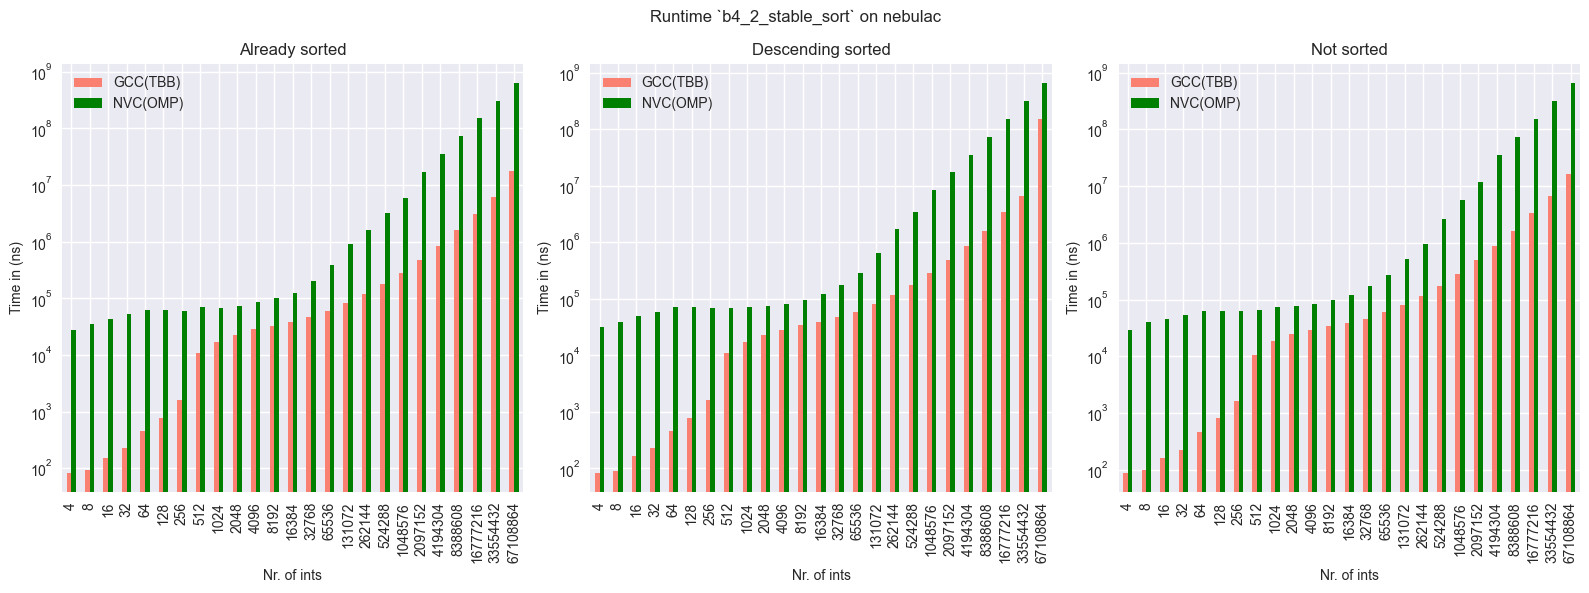

In [166]:
### Runtime

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')

fig.suptitle(f"Runtime `b4_2_stable_sort` on {device_name}")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Runtime on {device_name}")


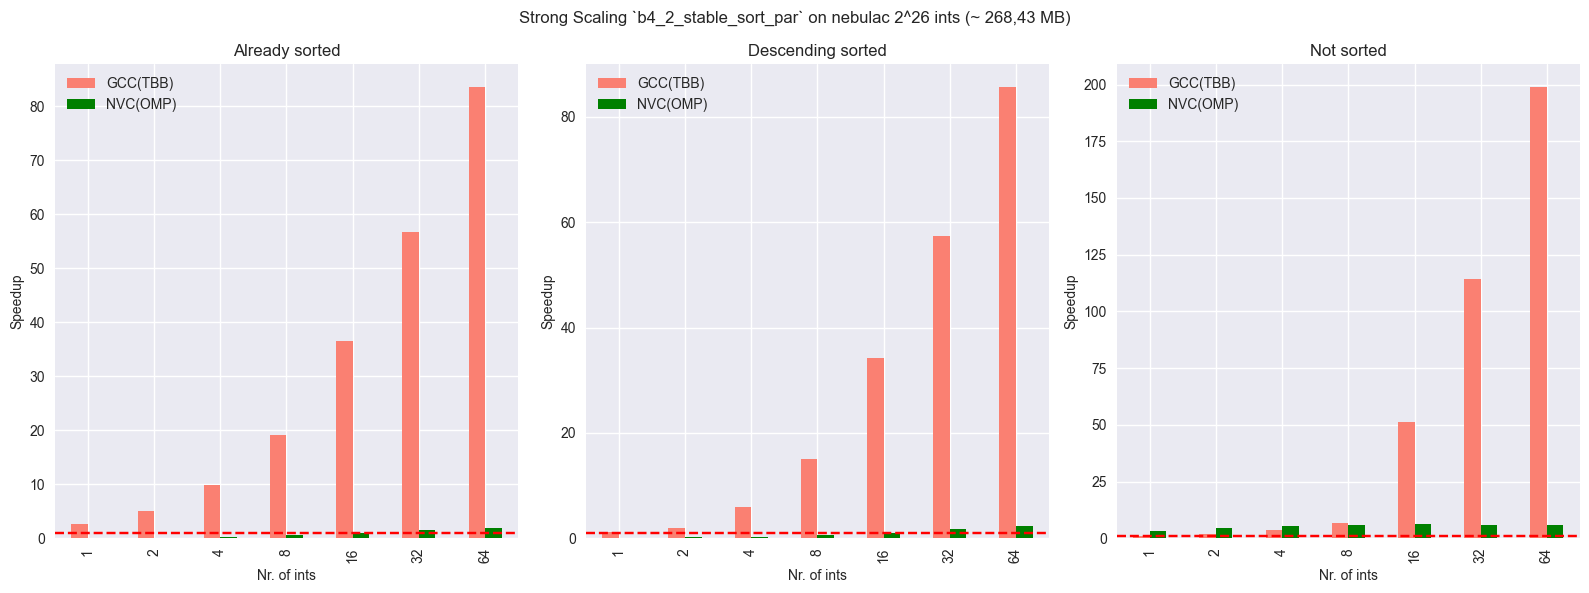

In [167]:
## stable sort strong scaling graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')
ax_2.axhline(y=1,color='r', linestyle='--')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')

fig.suptitle(f"Strong Scaling `b4_2_stable_sort_par` on {device_name} 2^26 ints (~ 268,43 MB)")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Strong Scaling on {device_name} 2^26 ints (~ 268,43 MB)")


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/3260990570.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/3260990570.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/3260990570.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


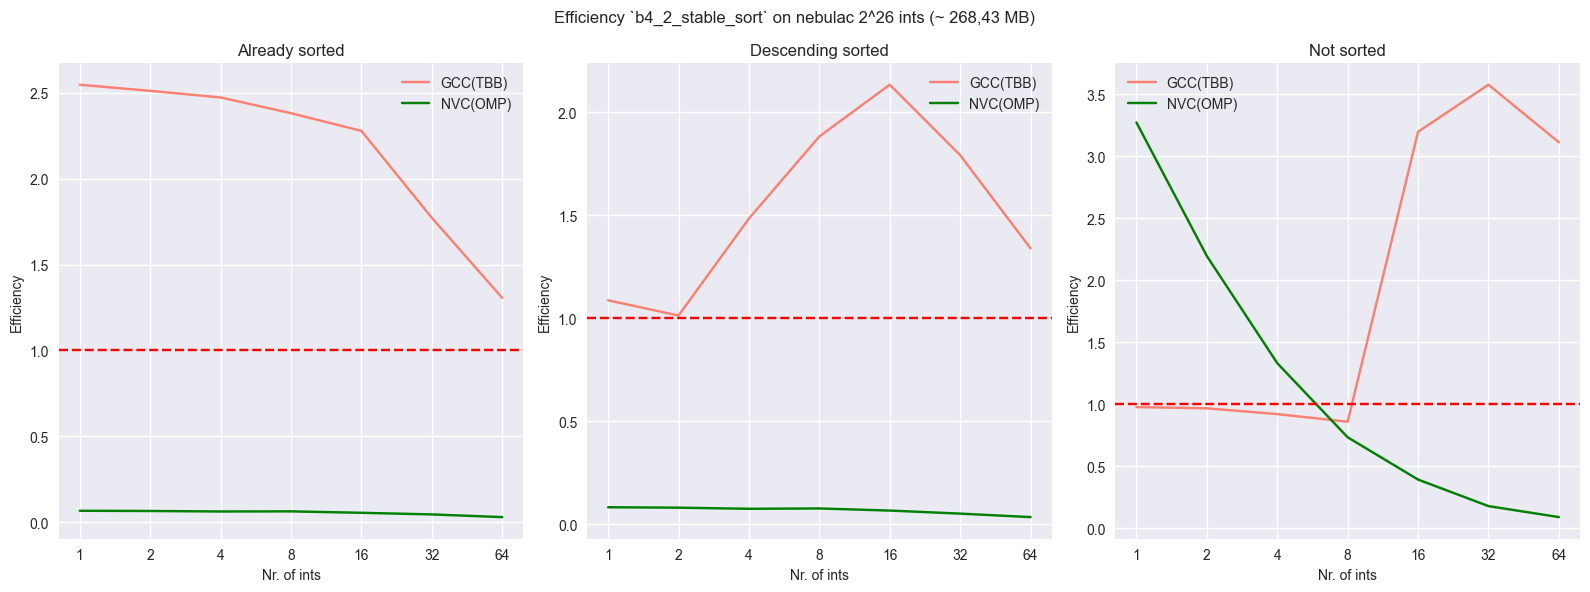

In [168]:
### efficiency stable sort

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')

#ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')
ax_2.axhline(y=1,color='r', linestyle='--')

#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')



ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle(f"Efficiency `b4_2_stable_sort` on {device_name} 2^26 ints (~ 268,43 MB)")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Efficiency on {device_name} 2^26 ints (~ 268,43 MB)")

### Mbytes/s

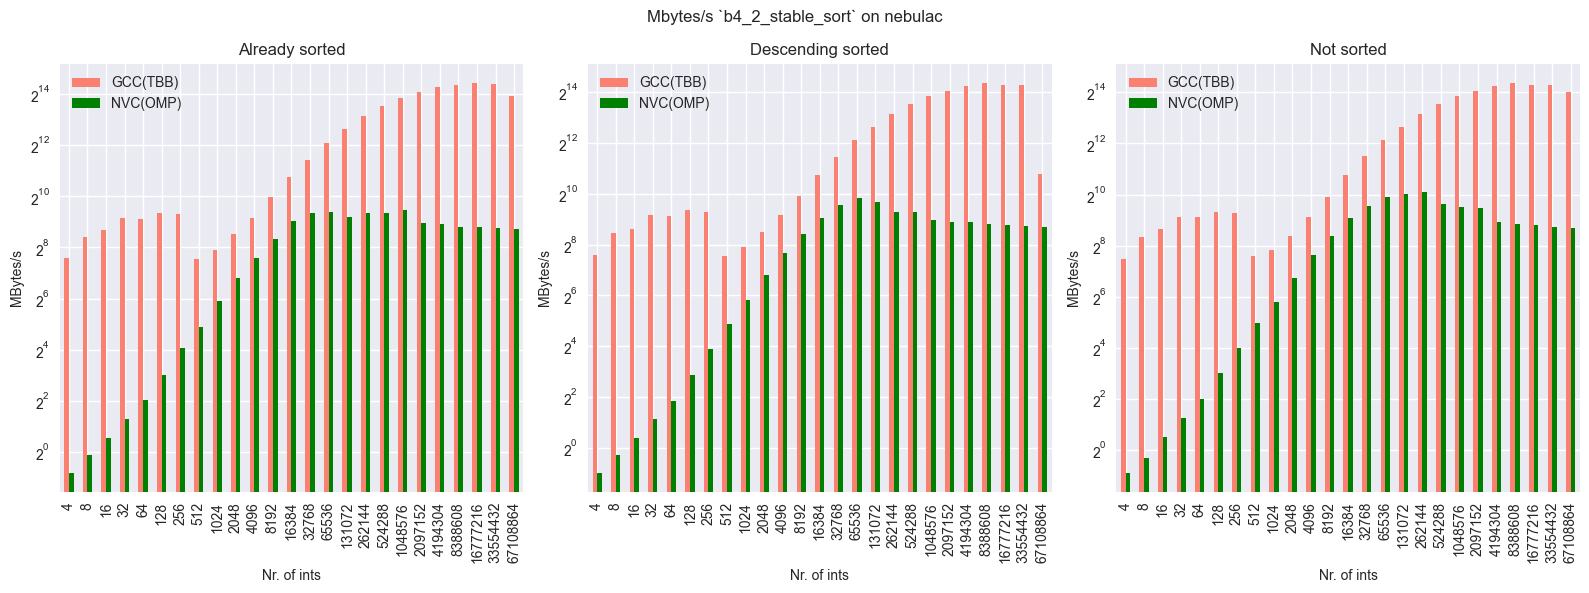

In [169]:
benchmark_names = [
    'b4_2_stable_sort_cutoff_already_sorted_par',
    'b4_2_stable_sort_cutoff_decrement_sorted_par',
    'b4_2_stable_sort_cutoff_not_sorted_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_2_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_2_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))



# plot already sorted
ax_1 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_already_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')




# plot decrement_sorted
ax_2 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_decrement_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')


# plot not_sorted
ax_3 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_not_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[2]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')


fig.suptitle(f"Mbytes/s `b4_2_stable_sort` on {device_name}")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Mbytes_s on {device_name}")

## `b4_3_set_union`

### Time Comparison - `b4_3_set_union_cutoff_one_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [170]:
def b4_3_set_union_cutoff_one_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_empty_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.172190e+01,4,8409.35
1,3.274730e+01,8,8496.56
2,3.274740e+01,16,8853.95
3,3.370120e+01,32,9488.27
4,3.371170e+01,64,11335.00
5,4.077050e+01,128,10454.00
6,5.345480e+01,256,9151.29
7,7.485180e+01,512,10967.10
8,3.662650e+04,1024,11298.20
9,4.158940e+04,2048,11239.20


### Time Comparison - `b4_3_set_union_cutoff_one_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [171]:
def b4_3_set_union_cutoff_one_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.372080e+01,4,9813.89
1,3.574590e+01,8,9982.73
2,4.010330e+01,16,10754.50
3,5.447040e+01,32,11483.30
4,9.320140e+01,64,12504.90
5,1.439700e+02,128,11557.70
6,2.418930e+02,256,11184.70
7,4.155660e+04,512,11040.70
8,4.511770e+04,1024,11057.20
9,5.084500e+04,2048,12468.60


### Time Comparison - `b4_3_set_union_cutoff_front_overhang_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [172]:
def b4_3_set_union_cutoff_front_overhang_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_front_overhang_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_front_overhang_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_front_overhang_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_front_overhang_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.371230e+01,4,11172.6
1,3.675650e+01,8,10643.8
2,4.478450e+01,16,10718.4
3,6.679970e+01,32,11862.4
4,1.051810e+02,64,12255.3
5,1.759690e+02,128,13453.1
6,3.134550e+02,256,13000.5
7,1.126460e+05,512,13101.6
8,1.107240e+05,1024,14377.6
9,1.111090e+05,2048,13778.3


### Strong Scaling - `b4_3_set_union_cutoff_one_empty_par`

1 Million fixed input size with threads 1-64

In [173]:
def get_b4_3_set_union_cutoff_one_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_3_set_union_cutoff_one_empty')
    
    ## b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_empty_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_empty_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.677961,0.105956
1,2,1.342912,0.211588
2,4,1.665434,0.422590
3,8,2.053569,0.845844
4,16,2.593860,1.687201
5,32,2.720041,2.858278
6,64,2.828725,5.076759


In [174]:
# efficiency b4_3_set_union_cutoff_one_empty_par
b4_3_set_union_cutoff_one_empty_efficiency = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_empty_efficiency['threads']



b4_3_set_union_cutoff_one_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.677961,0.105956
1,2,0.671456,0.105794
2,4,0.416359,0.105648
3,8,0.256696,0.105730
4,16,0.162116,0.105450
5,32,0.085001,0.089321
6,64,0.044199,0.079324


### Strong Scaling - `b4_3_set_union_cutoff_one_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [175]:
def get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_3_set_union_cutoff_one_wholly_greater')
    
    ## b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_wholly_greater_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.135492,0.285199
1,2,1.397213,0.476997
2,4,2.753444,0.648707
3,8,3.602627,0.922675
4,16,4.246122,1.052743
5,32,4.514244,1.127881
6,64,4.750900,1.114716


In [176]:

# efficiency b4_3_set_union_cutoff_one_wholly_greater_par
b4_3_set_union_cutoff_one_wholly_greater_efficiency = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_wholly_greater_efficiency['threads']



b4_3_set_union_cutoff_one_wholly_greater_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.135492,0.285199
1,2,0.698607,0.238499
2,4,0.688361,0.162177
3,8,0.450328,0.115334
4,16,0.265383,0.065796
5,32,0.141070,0.035246
6,64,0.074233,0.017417


### Strong Scaling - `b4_3_set_union_cutoff_front_overhang_par`

1 Million fixed input size with threads 1-64

In [177]:
def get_b4_3_set_union_cutoff_front_overhang_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_3_set_union_cutoff_front_overhang')
    
    ## b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_front_overhang_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_front_overhang_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.677216,0.482932
1,2,0.944470,0.732599
2,4,1.358826,0.914484
3,8,1.495994,1.018445
4,16,1.357974,1.068005
5,32,1.443830,0.964230
6,64,1.339768,0.997565


In [178]:
# efficiency b4_3_set_union_cutoff_front_overhang_par
b4_3_set_union_cutoff_front_overhang_efficiency = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_front_overhang_efficiency['threads']



b4_3_set_union_cutoff_front_overhang_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.677216,0.482932
1,2,0.472235,0.366300
2,4,0.339706,0.228621
3,8,0.186999,0.127306
4,16,0.084873,0.066750
5,32,0.045120,0.030132
6,64,0.020934,0.015587


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/1367863599.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_1.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/1367863599.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_2.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/1367863599.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_3.set_ylim(0,y_lim)


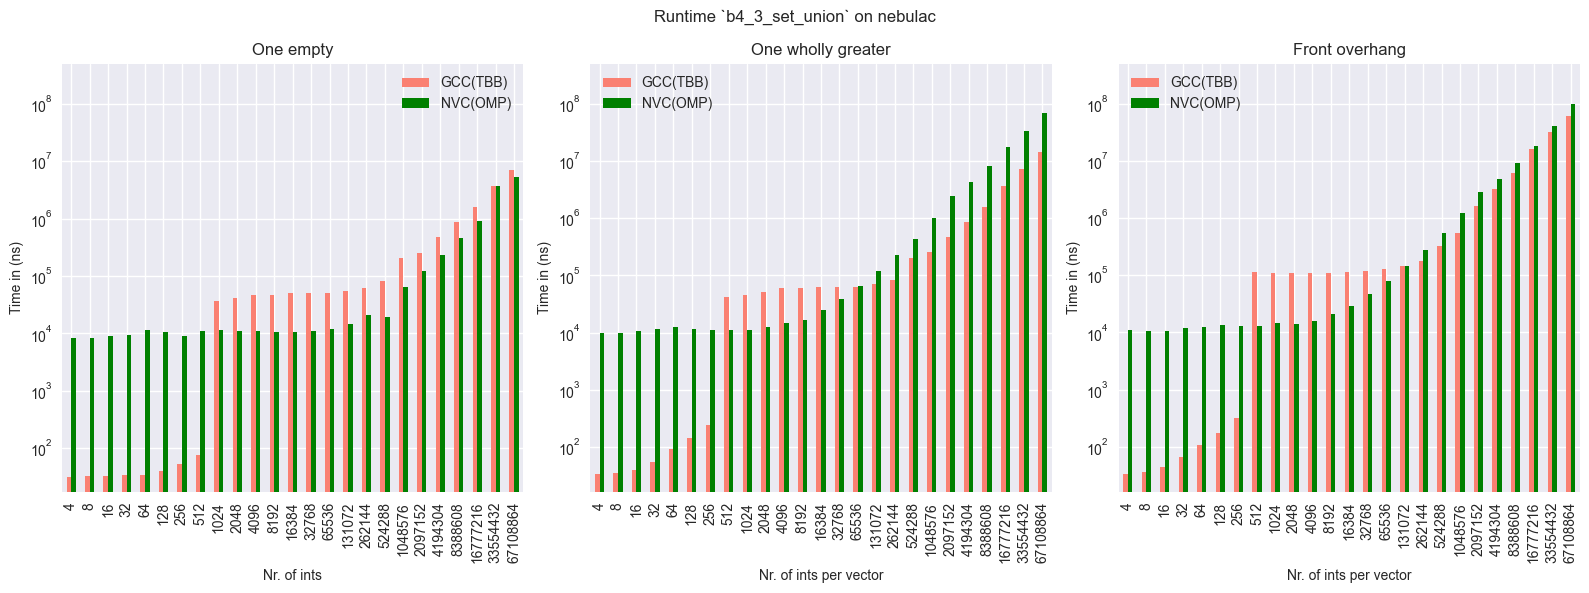

In [179]:
# all set_union graphs

y_lim = 5*pow(10,8)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('One empty')
ax_1.set_ylim(0,y_lim)

# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints per vector')
ax_2.set_title('One wholly greater')
ax_2.set_ylim(0,y_lim)


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Front overhang')
ax_3.set_ylim(0,y_lim)

fig.suptitle(f"Runtime `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Runtime on {device_name}")

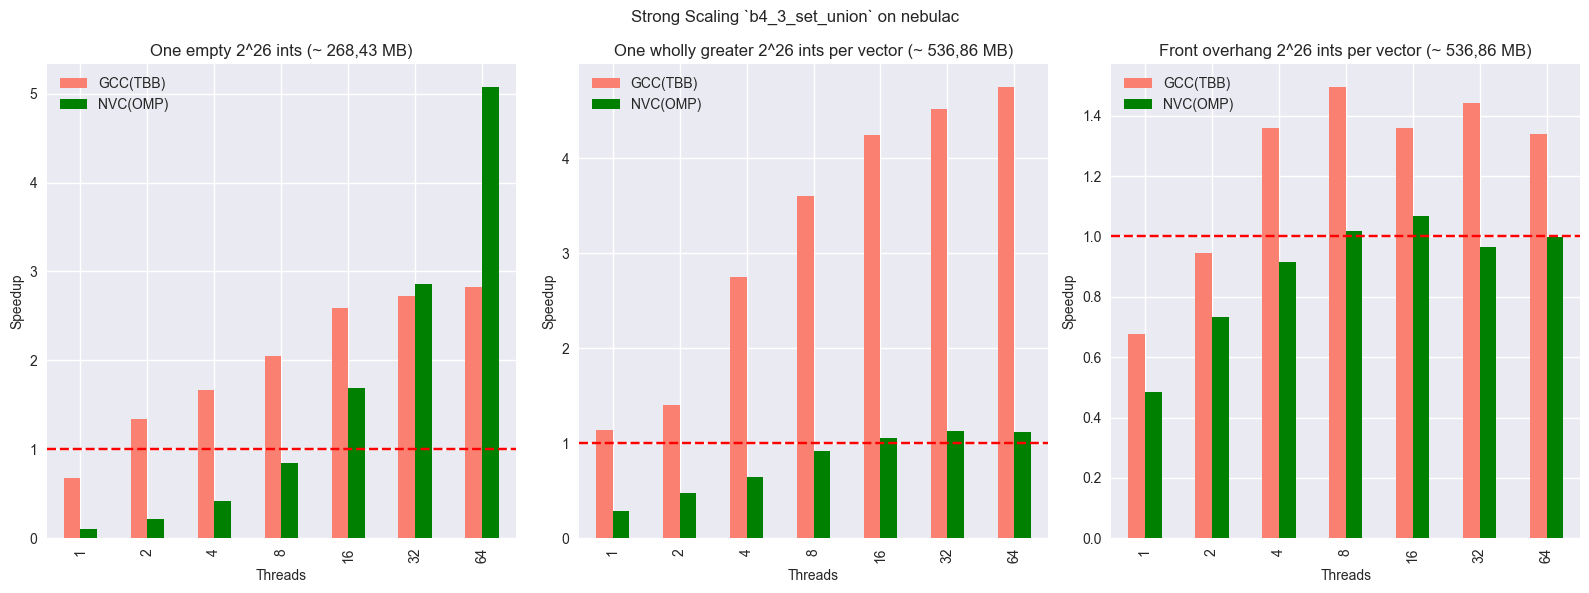

In [180]:
# all set_union graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('One empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
#ax_1.set_ylim(0,3)

# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('One wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
#ax_2.set_ylim(0,3)


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Threads')
ax_3.set_title('Front overhang 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
#ax_3.set_ylim(0,3)


fig.suptitle(f"Strong Scaling `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Strong Scaling on {device_name}")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/2777024957.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/2777024957.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/2777024957.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


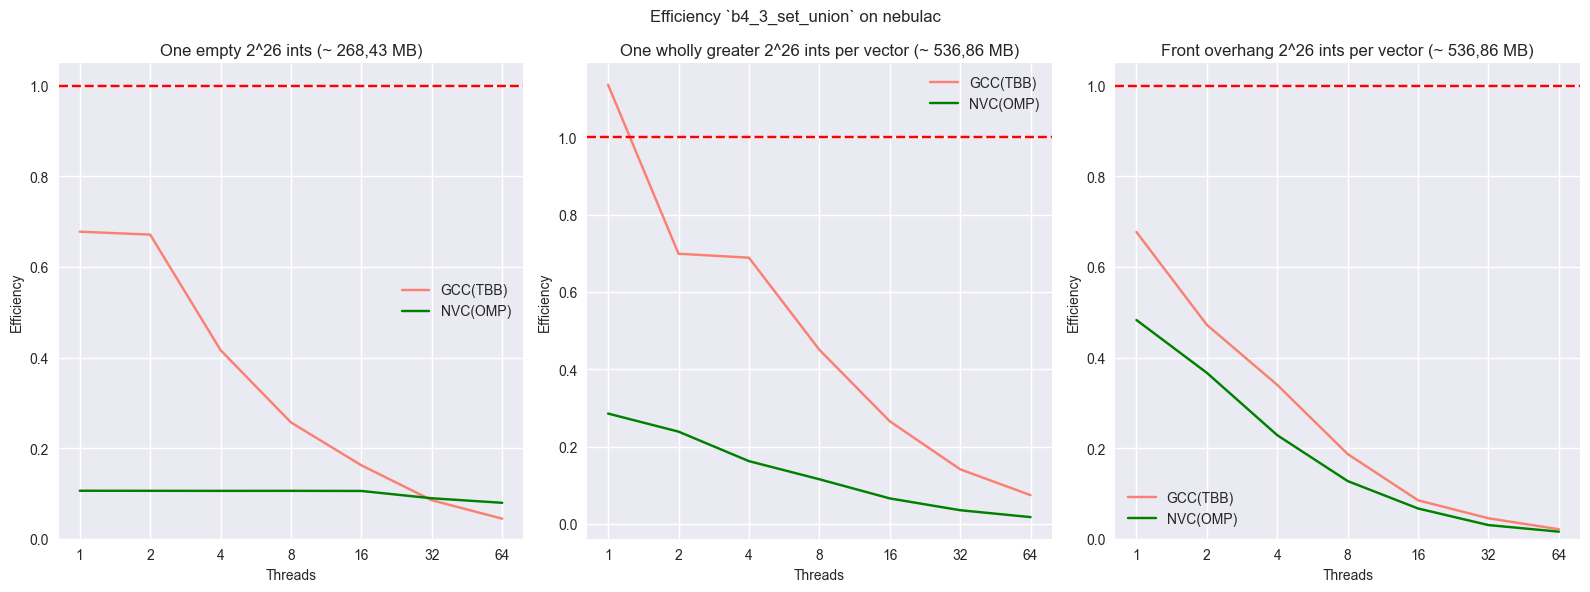

In [181]:
# efficiency  set_union graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Threads')
ax_1.set_title('One empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Threads')
ax_2.set_title('One wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Front overhang 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle(f"Efficiency `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Efficiency on {device_name}")

### Mbytes/s

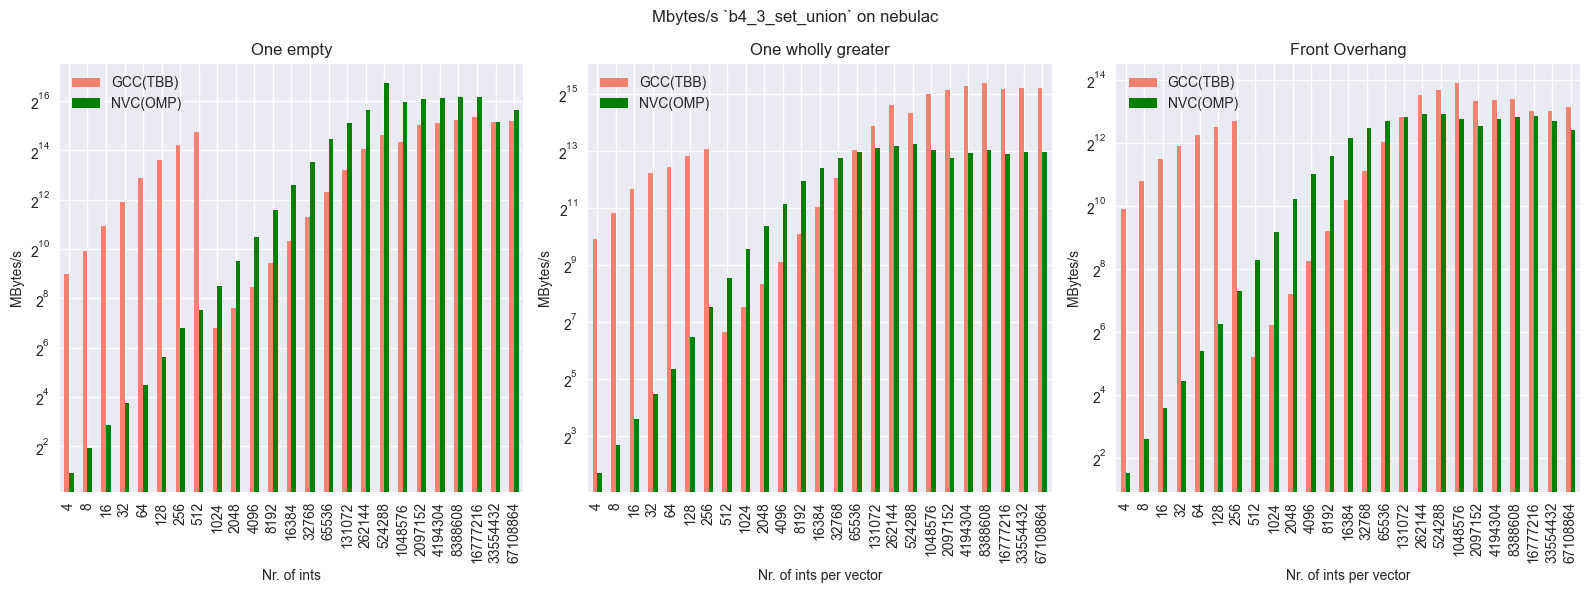

In [182]:
benchmark_names = [
    'b4_3_set_union_cutoff_one_empty_par',
    'b4_3_set_union_cutoff_one_wholly_greater_par',
    'b4_3_set_union_cutoff_front_overhang_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_3_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_3_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))

#ylim = (0,pow(2,15))


# plot one empty
ax_1 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('One empty')
#ax_1.set_ylim(0,2*pow(2,14))



# plot wholey greater
ax_2 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_wholly_greater_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints per vector')
ax_2.set_title('One wholly greater')
#ax_2.set_ylim(*ylim)


# plot front_overhang
ax_3 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_front_overhang_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[2]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Front Overhang')
#ax_3.set_ylim(*ylim)


fig.suptitle(f"Mbytes/s `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Mbytes_s on {device_name}")

## `b4_4_set_difference`

### Time Comparison - `b4_4_set_difference_cutoff_left_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [183]:
def b4_4_set_difference_cutoff_left_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_left_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_left_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_left_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_left_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,33.7552,4,33.4474
1,33.7512,8,33.4482
2,33.7530,16,33.2423
3,33.7510,32,33.1737
4,33.7523,64,33.4403
5,33.7505,128,33.3981
6,33.7540,256,33.3614
7,33.7522,512,33.3420
8,33.7538,1024,33.3945
9,33.7530,2048,33.3756


### Time Comparison - `b4_4_set_difference_cutoff_right_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [184]:
def b4_4_set_difference_cutoff_right_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_right_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_right_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_right_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_right_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,4847.77,4,9353.19
1,14337.00,8,9410.22
2,19045.70,16,9350.51
3,24684.20,32,10476.40
4,27987.90,64,11623.20
5,29600.90,128,11254.10
6,31175.90,256,10324.40
7,33675.70,512,9647.08
8,36040.10,1024,9590.90
9,40380.10,2048,9563.42


### Time Comparison - `b4_4_set_difference_cutoff_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [185]:
def b4_4_set_difference_cutoff_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,5356.15,4,3.474750e+01
1,13511.80,8,3.740000e+01
2,19225.30,16,4.273790e+01
3,23941.40,32,5.525730e+01
4,27129.10,64,9.249900e+01
5,28341.90,128,1.351610e+02
6,30050.70,256,2.210260e+02
7,33390.50,512,3.920540e+02
8,35899.70,1024,7.339470e+02
9,40610.60,2048,1.418330e+03


### Time Comparison - `b4_4_set_difference_cutoff_intersected_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [186]:
def b4_4_set_difference_cutoff_intersected_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_intersected_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_intersected_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_intersected_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_intersected_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.865700e+01,4,3.640080e+01
1,4.677070e+01,8,3.966030e+01
2,7.119610e+01,16,4.673370e+01
3,1.108630e+02,32,6.230450e+01
4,1.884910e+02,64,1.025140e+02
5,3.396870e+02,128,1.461940e+02
6,6.409210e+02,256,2.320120e+02
7,9.737190e+04,512,4.087030e+02
8,1.002260e+05,1024,7.454270e+02
9,9.639700e+04,2048,1.429510e+03


### Strong Scaling - `b4_4_set_difference_cutoff_left_empty_par`

1 Million fixed input size with threads 1-64

In [187]:
def get_b4_4_set_difference_cutoff_left_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_left_empty')
    
    
    ## b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_left_empty_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_left_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged


,threads,GCC(TBB),NVC(OMP)
0,1,0.917704,0.929478
1,2,0.920301,0.929405
2,4,0.917818,0.934939
3,8,0.920355,0.928885
4,16,0.920183,0.928583
5,32,0.920077,0.931091
6,64,0.919968,0.928203


In [188]:
# efficiency b4_4_set_difference_cutoff_left_empty_par
b4_4_set_difference_cutoff_left_empty_efficiency = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_left_empty_efficiency['threads']



b4_4_set_difference_cutoff_left_empty_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,0.917704,0.929478
1,2,0.460150,0.464703
2,4,0.229454,0.233735
3,8,0.115044,0.116111
4,16,0.057511,0.058036
5,32,0.028752,0.029097
6,64,0.014375,0.014503


### Strong Scaling - `b4_4_set_difference_cutoff_right_empty_par`

1 Million fixed input size with threads 1-64

In [189]:
def get_b4_4_set_difference_cutoff_right_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    

    ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_right_empty')
    
    ## b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_right_empty_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_right_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.682146,0.106196
1,2,0.884782,0.212364
2,4,1.652378,0.423942
3,8,2.377944,0.848585
4,16,2.625460,1.691548
5,32,2.772575,2.770108
6,64,2.820702,4.263823


In [190]:
# efficiency b4_4_set_difference_cutoff_right_empty_par
b4_4_set_difference_cutoff_right_empty_efficiency = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_right_empty_efficiency['threads']



b4_4_set_difference_cutoff_right_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.682146,0.106196
1,2,0.442391,0.106182
2,4,0.413095,0.105986
3,8,0.297243,0.106073
4,16,0.164091,0.105722
5,32,0.086643,0.086566
6,64,0.044073,0.066622


#### Strong Scaling - `b4_4_set_difference_cutoff_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [191]:
def get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_wholly_greater')
    
    ## b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_wholly_greater_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.580574,0.996029
1,2,3.179405,1.006786
2,4,3.871525,0.977732
3,8,4.999246,0.943811
4,16,6.099788,0.916512
5,32,6.388558,0.907216
6,64,6.586378,0.843818


In [192]:

# efficiency b4_4_set_difference_cutoff_wholly_greater_par
b4_4_set_difference_cutoff_wholly_greater_efficiency = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_wholly_greater_efficiency['threads']



b4_4_set_difference_cutoff_wholly_greater_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,1.580574,0.996029
1,2,1.589702,0.503393
2,4,0.967881,0.244433
3,8,0.624906,0.117976
4,16,0.381237,0.057282
5,32,0.199642,0.028350
6,64,0.102912,0.013185


### Strong Scaling - `b4_4_set_difference_cutoff_intersected_par`

1 Million fixed input size with threads 1-64

In [193]:
def get_b4_4_set_difference_cutoff_intersected_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
     ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_intersected')
    
    ## b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_intersected_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_intersected_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_intersected_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_intersected_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.503555,1.455107
1,2,1.006911,1.452262
2,4,2.002233,1.420615
3,8,3.944745,1.399962
4,16,7.357791,1.193077
5,32,9.683783,1.221638
6,64,10.442240,1.279801


In [194]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_4_set_difference_cutoff_intersected_efficiency = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_intersected_efficiency['threads']



b4_4_set_difference_cutoff_intersected_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,0.503555,1.455107
1,2,0.503455,0.726131
2,4,0.500558,0.355154
3,8,0.493093,0.174995
4,16,0.459862,0.074567
5,32,0.302618,0.038176
6,64,0.163160,0.019997


### Plots

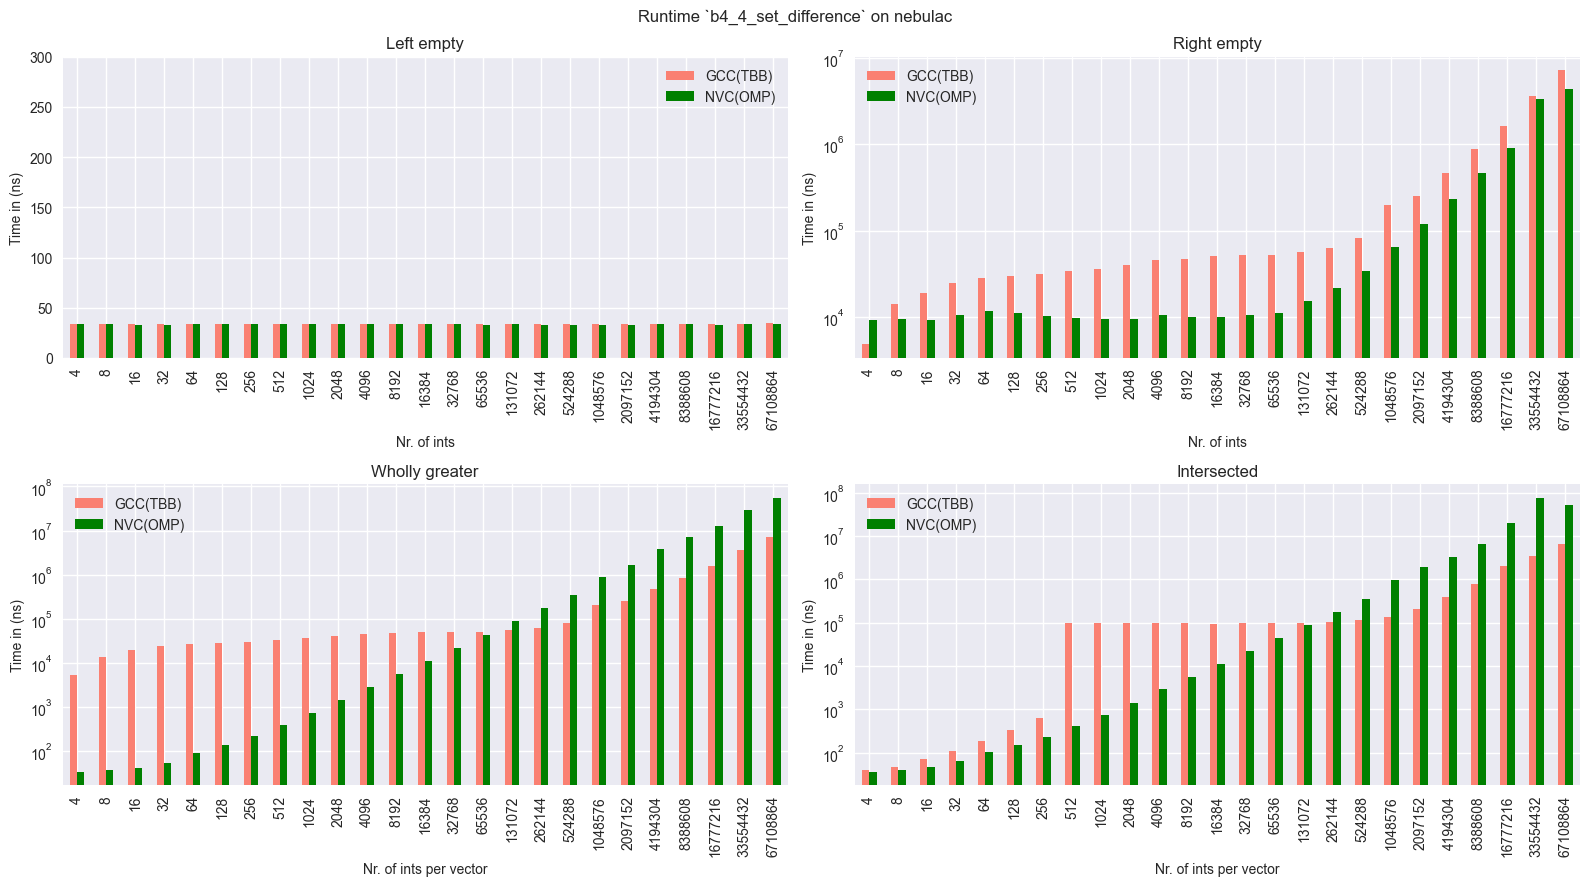

In [195]:
# all set_difference graphs

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Left empty')
ax_1.set_ylim(0,300)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Right empty')


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Wholly greater')


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_yscale('log', base=10)
ax_4.set_ylabel('Time in (ns)')
ax_4.set_xlabel('Nr. of ints per vector')
ax_4.set_title('Intersected')

fig.suptitle(f"Runtime `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Runtime on {device_name}")

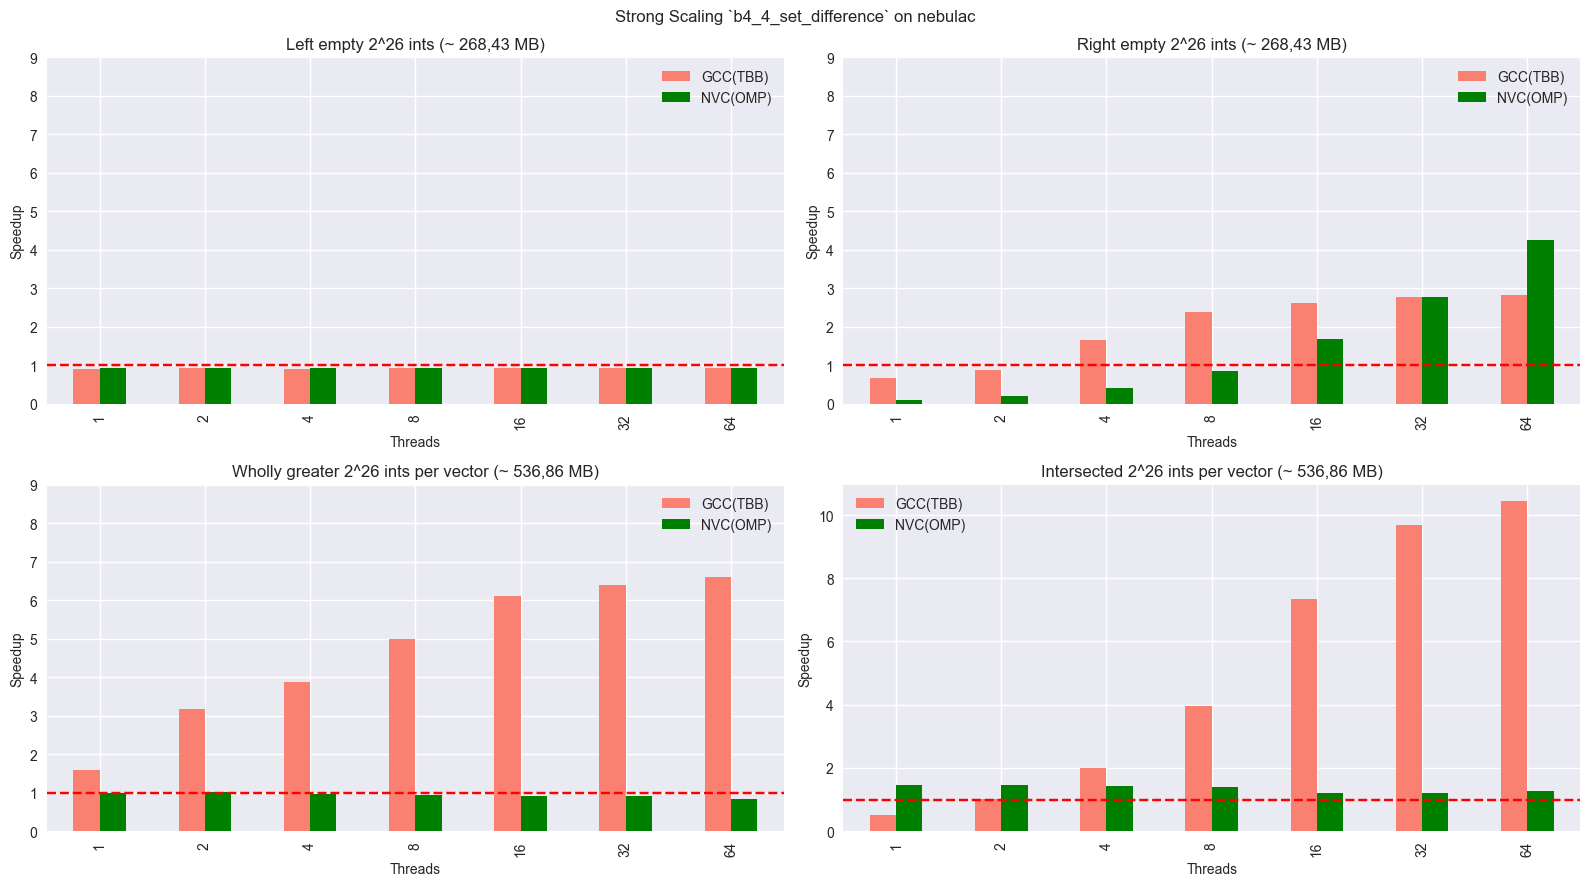

In [196]:
# strong scaling graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('Left empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,9)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Right empty 2^26 ints (~ 268,43 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,9)

# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Threads')
ax_3.set_title('Wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,9)

# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Speedup')
ax_4.set_xlabel('Threads')
ax_4.set_title('Intersected 2^26 ints per vector (~ 536,86 MB)')
ax_4.axhline(y=1, color='r',linestyle='--')
#ax_4.set_ylim(0,9)

fig.suptitle(f"Strong Scaling `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Strong Scaling on {device_name}")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/204873550.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/204873550.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/204873550.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11874/204873550.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


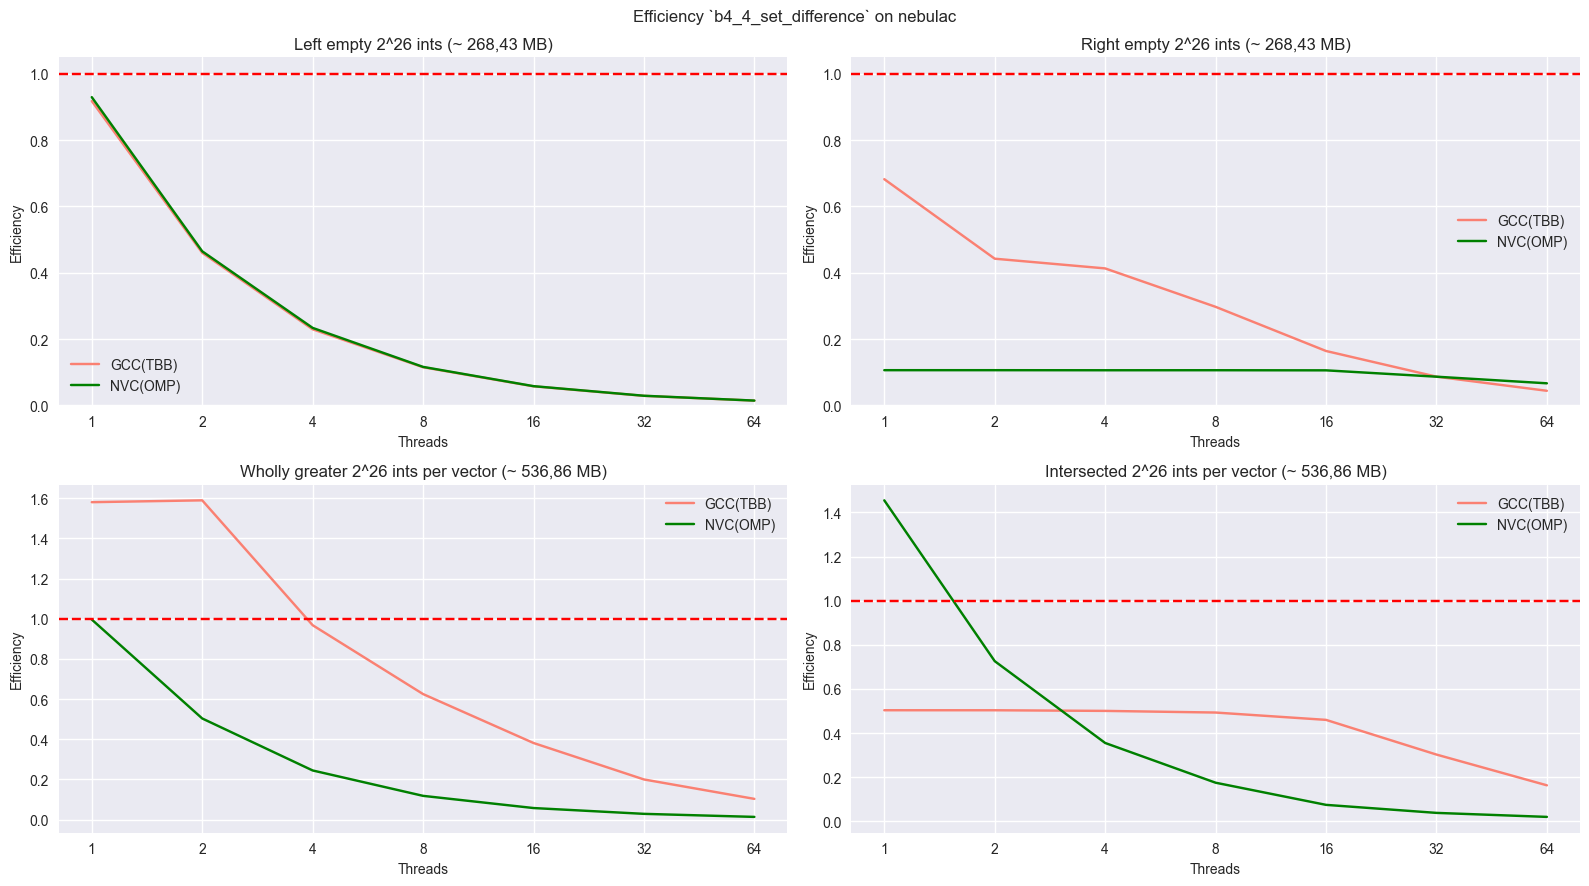

In [197]:
# efficiency graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Threads')
ax_1.set_title('Left empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Threads')
ax_2.set_title('Right empty 2^26 ints (~ 268,43 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')


ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Efficiency')
ax_4.set_xlabel('Threads')
ax_4.set_title('Intersected 2^26 ints per vector (~ 536,86 MB)')
ax_4.axhline(y=1, color='r',linestyle='--')


ax_4.set_xscale('log', base=2)
current_values = ax_4.get_xticks()
ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])




fig.suptitle(f"Efficiency `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Efficiency on {device_name}")

### Mbytes/s

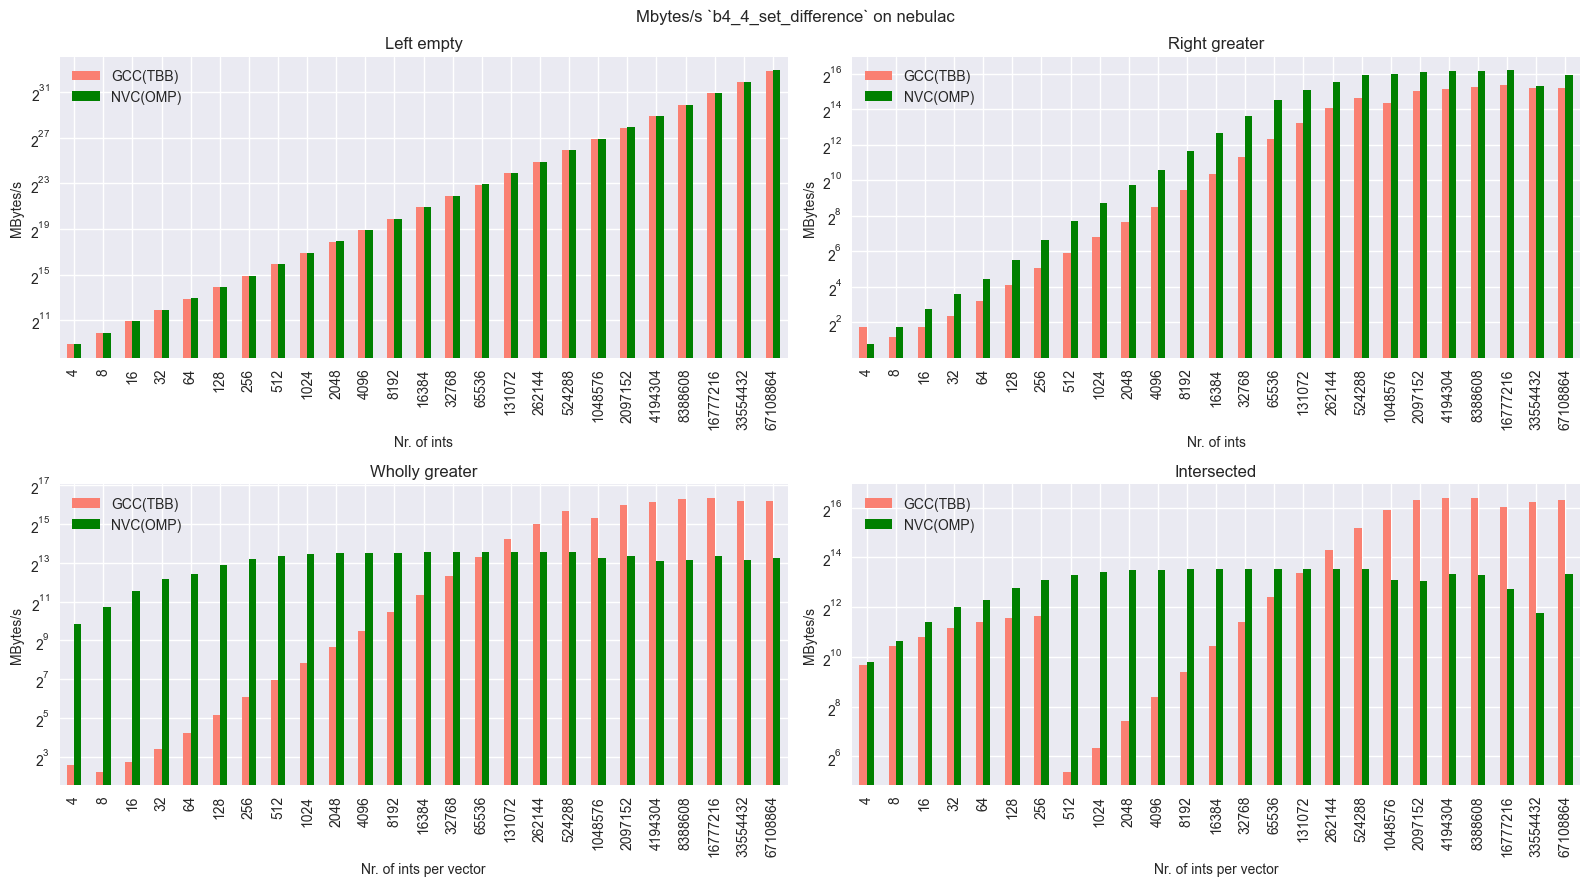

In [198]:
benchmark_names = [
    'b4_4_set_difference_cutoff_left_empty_par',
    'b4_4_set_difference_cutoff_right_empty_par',
    'b4_4_set_difference_cutoff_wholly_greater_par',
    'b4_4_set_difference_cutoff_intersected_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_4_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_4_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')




fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))



# plot left_empty
ax_1 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_left_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0,0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Left empty')




# plot right empty
ax_2 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_right_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0,1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Right greater')


# plot front_overhang
ax_3 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_wholly_greater_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1,0]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Wholly greater')



# plot intersected
ax_4 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_intersected_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1,1]
                                                    )

ax_4.set_yscale('log',base=2)
ax_4.set_ylabel('MBytes/s')
ax_4.set_xlabel('Nr. of ints per vector')
ax_4.set_title('Intersected')


fig.suptitle(f"Mbytes/s `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Mbytes_s on {device_name}")

## Performance Portability Calculation (Inter Compiler)

In [199]:
def calc_pp(data_points:List[int]) -> int:
    max_val = max(data_points)
    return len(data_points) / sum([1/(val/max_val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('B4_1',b4_1_mbytes_sec_data),
    
    ('B4_2_already_sorted',b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_already_sorted_par']),
    ('B4_2_decrement_sorted',b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_decrement_sorted_par']),
    ('B4_2_not_sorted',b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_not_sorted_par']),
    
    ('b4_3_one_empty',b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_empty_par']),
    ('b4_3_wholly_greater',b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_wholly_greater_par']),
    ('b4_3_front_overhang',b4_3_mbytes_sec_data['b4_3_set_union_cutoff_front_overhang_par']),
    
    ('b4_4_left_empty',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_left_empty_par']),
    ('b4_4_right_empty',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_right_empty_par']),
    ('b4_4_wholly_greater',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_wholly_greater_par']),
    ('b4_4_intersected',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_intersected_par']),
]


for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df

,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,B4_1,27511,6368,0.375926,BAD
1,B4_2_already_sorted,15408,426,0.053808,BAD
2,B4_2_decrement_sorted,1760,411,0.378627,BAD
3,B4_2_not_sorted,16675,414,0.048452,BAD
4,b4_3_one_empty,37892,51010,0.852444,GOOD
5,b4_3_wholly_greater,37216,7927,0.351195,BAD
6,b4_3_front_overhang,8975,5377,0.749303,BAD
7,b4_4_left_empty,7826990000,8063000000,0.985147,GOOD
8,b4_4_right_empty,37634,61920,0.756052,BAD
9,b4_4_wholly_greater,74421,9718,0.230999,BAD


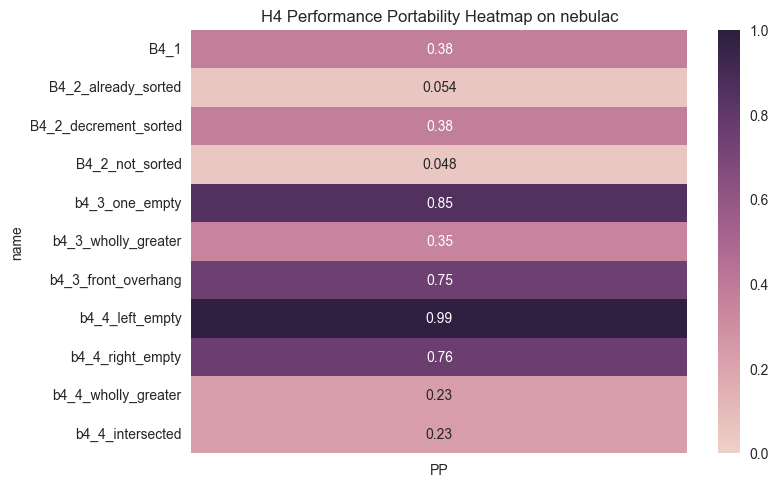

In [200]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H4 Performance Portability Heatmap on {device_name}')

plot(f'H4 Performance Portability Heatmap on {device_name}')

## Findings for H4

### Findings `b4_1_merge`



### Findings `b4_2_stable_sort`



### Findings `b4_3_set_union`



### Findings `b4_4_set_difference`



### General



### GPU Findings



### Hypothesis Findings

